Loaded 16 training images
Loaded 4 validation images
Loaded 20 test images
cuda


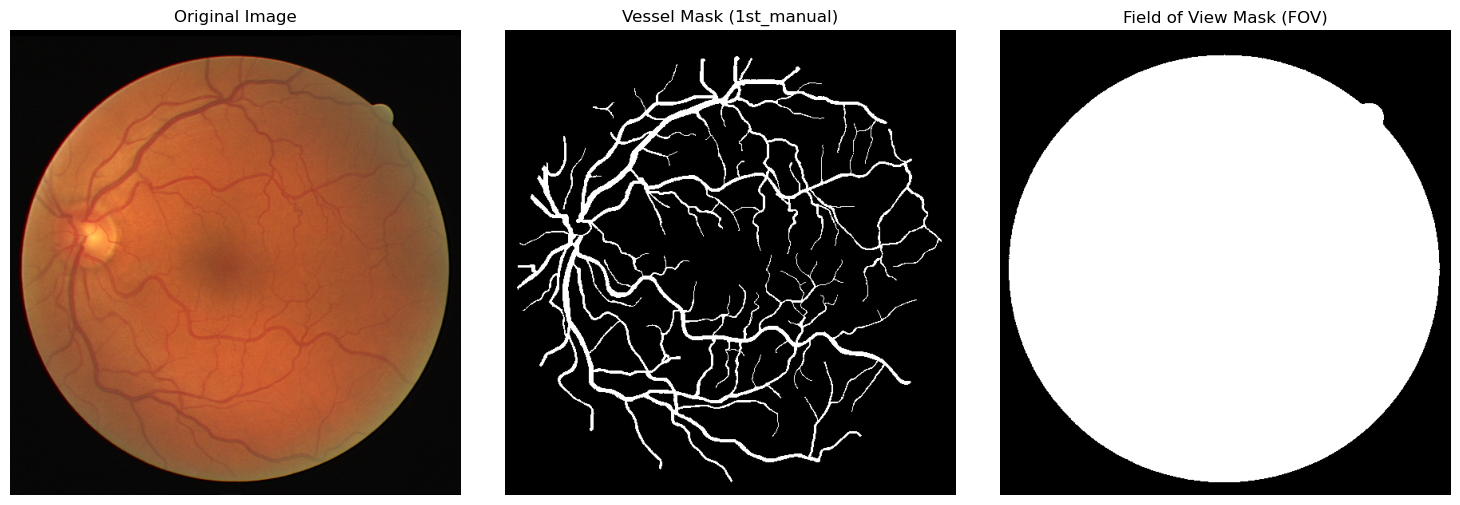

In [1]:
import os
import glob
import PIL.Image as Image
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import numpy as np

data_path = '/dtu/datasets1/02516/DRIVE'

class DRIVEDataLoader(torch.utils.data.Dataset):
    def __init__(self, train=True, transform=None, data_path=data_path):
        'Initialization'
        self.transform = transform
        if train:
            # Training data
            image_folder = os.path.join(data_path, 'training', 'images')
            vessel_mask_folder = os.path.join(data_path, 'training', '1st_manual')  # Vessel masks for training
            fov_mask_folder = os.path.join(data_path, 'training', 'mask')  # Field of view masks for training
        else:
            # Test data
            image_folder = os.path.join(data_path, 'test', 'images')
            fov_mask_folder = os.path.join(data_path, 'test', 'mask')  # Only FOV masks are available for test set
            vessel_mask_folder = None  # No vessel mask for test set

        # Get image paths
        self.image_paths = sorted(glob.glob(os.path.join(image_folder, '*.tif')))

        # Get vessel mask paths if available (for training)
        if vessel_mask_folder:
            self.vessel_mask_paths = sorted(glob.glob(os.path.join(vessel_mask_folder, '*.gif')))
        else:
            self.vessel_mask_paths = [None] * len(self.image_paths)  # No vessel mask for test set

        # Get FOV mask paths
        self.fov_mask_paths = sorted(glob.glob(os.path.join(fov_mask_folder, '*.gif')))
        
        # Check if we have found the files
        if len(self.image_paths) == 0 or len(self.fov_mask_paths) == 0:
            raise ValueError(f"No images or masks found in the provided path: {data_path}")

        if train and len(self.image_paths) != len(self.vessel_mask_paths):
            raise ValueError("Mismatch between the number of images and vessel masks in the training set.")

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        vessel_mask_path = self.vessel_mask_paths[idx]
        fov_mask_path = self.fov_mask_paths[idx]

        # Load the image
        image = Image.open(image_path)

        # Load the vessel mask (if available, i.e., for training)
        vessel_mask = Image.open(vessel_mask_path) if vessel_mask_path else None

        # Load the FOV mask
        fov_mask = Image.open(fov_mask_path)

        # Apply transforms to the image and masks
        if self.transform:
            image = self.transform(image)
            fov_mask = self.transform(fov_mask)
            if vessel_mask:
                vessel_mask = self.transform(vessel_mask)

        # Apply FOV mask to both image and vessel mask if available
        if vessel_mask:
            image = image * fov_mask
            vessel_mask = vessel_mask * fov_mask
            return image, vessel_mask  # Return both image and vessel mask for training

        # For test set, return only the FOV-masked image and FOV mask
        return image, fov_mask

# Define transformations to resize and convert images to tensors
size = 128
transform = transforms.Compose([
    transforms.Resize((size, size)), 
    transforms.ToTensor()
])

# Create DataLoader for the dataset
batch_size = 6

# Create the full training set
full_trainset = DRIVEDataLoader(train=True, transform=transform)

# Define the train-validation split ratio (80% train, 20% validation)
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size

# Split the dataset into training and validation sets
trainset, valset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

# Create the test set
testset = DRIVEDataLoader(train=False, transform=transform)

# Create the DataLoaders for train, validation, and test sets
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=3)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

# Print data sizes
print(f'Loaded {len(trainset)} training images')
print(f'Loaded {len(valset)} validation images')
print(f'Loaded {len(testset)} test images')

# Example of loading a batch of images from the training set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



# Function to visualize the images and masks side-by-side
def visualize_masks(image_path, vessel_mask_path, fov_mask_path):
    # Load the image and masks
    image = Image.open(image_path)
    vessel_mask = Image.open(vessel_mask_path)
    fov_mask = Image.open(fov_mask_path)

    # Convert them to numpy arrays for visualization
    image_np = np.array(image)
    vessel_mask_np = np.array(vessel_mask)
    fov_mask_np = np.array(fov_mask)

    # Plot all three images side-by-side
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image_np, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Vessel Mask (1st_manual)')
    plt.imshow(vessel_mask_np, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Field of View Mask (FOV)')
    plt.imshow(fov_mask_np, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Define paths for a random example
train_image_folder = os.path.join(data_path, 'training', 'images')
vessel_mask_folder = os.path.join(data_path, 'training', '1st_manual')
fov_mask_folder = os.path.join(data_path, 'training', 'mask')

# Get list of images and masks
image_paths = sorted(glob.glob(os.path.join(train_image_folder, '*.tif')))
vessel_mask_paths = sorted(glob.glob(os.path.join(vessel_mask_folder, '*.gif')))
fov_mask_paths = sorted(glob.glob(os.path.join(fov_mask_folder, '*.gif')))

# Pick a random index to visualize
random_idx = random.randint(0, len(image_paths) - 1)

# Get the corresponding paths for the image and masks
example_image_path = image_paths[random_idx]
example_vessel_mask_path = vessel_mask_paths[random_idx]
example_fov_mask_path = fov_mask_paths[random_idx]

# Call the function to visualize the images and masks
visualize_masks(example_image_path, example_vessel_mask_path, example_fov_mask_path)